# Deploy a BigQuery ML user churn propensity model to Vertex AI for online predictions

## Learning objectives

* Explore and preprocess a [Google Analytics 4](https://support.google.com/analytics/answer/7029846) data sample in [BigQuery](https://cloud.google.com/bigquery) for machine learning.  
* Train a [BigQuery ML (BQML)](https://cloud.google.com/bigquery-ml) [XGBoost](https://xgboost.readthedocs.io/en/latest/) classifier to predict user churn on a mobile gaming application.
* Tune a BQML XGBoost classifier using [BQML hyperparameter tuning features](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-boosted-tree).
* Evaluate the performance of a BQML XGBoost classifier.
* Explain your XGBoost model with [BQML Explainable AI](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-xai-overview) global feature attributions.
* Generate batch predictions with your BQML XGBoost model.
* Export a BQML XGBoost model to a [Google Cloud Storage](https://cloud.google.com/storage).
* Upload and deploy a BQML XGBoost model to a [Vertex AI Prediction](https://cloud.google.com/vertex-ai/docs/predictions/getting-predictions) Endpoint for online predictions.

## Introduction

In this lab, you will train, evaluate, explain, and generate batch and online predictions with a BigQuery ML (BQML) XGBoost model. You will use a Google Analytics 4 dataset from a real mobile application, Flood it! ([Android app](https://play.google.com/store/apps/details?id=com.labpixies.flood), [iOS app](https://itunes.apple.com/us/app/flood-it!/id476943146?mt=8)), to determine the likelihood of users returning to the application. You will generate batch predictions with your BigQuery ML model as well as export and deploy it to **Vertex AI** for online predictions.

[BigQuery ML](https://cloud.google.com/bigquery-ml/docs/introduction) lets you train and do batch inference with machine learning models in BigQuery using standard SQL queries faster by eliminating the need to move data with fewer lines of code. [Vertex AI](https://cloud.google.com/vertex-ai) is Google Cloud's complimentary next generation, unified platform for machine learning development. By developing and deploying BQML machine learning solutions on Vertex AI, you can leverage a scalable online prediction service and MLOps tools for model retraining and monitoring to significantly enhance your development productivity, the ability to scale your workflow and decision making with your data, and accelerate time to value.

![BQML Vertex AI](./images/vertex-bqml-lab-architecture-diagram.png "Vertex BQML Lab Architecture Diagram")

Note: this lab is inspired by and extends [Churn prediction for game developers using Google Analytics 4 (GA4) and BigQuery ML](https://cloud.google.com/blog/topics/developers-practitioners/churn-prediction-game-developers-using-google-analytics-4-ga4-and-bigquery-ml). See that blog post and accompanying tutorial for additional depth on this use case and BigQuery ML. In this lab, you will go one step further and focus on how Vertex AI extends BQML's capabilities through online prediction so you can incorporate both customer churn predictions into decision making UIs such as [Looker dashboards](https://looker.com/google-cloud) but also online predictions directly into customer applications to power targeted interventions such as targeted incentives.

### Use case: user churn propensity modeling in the mobile gaming industry

According to a [2019 study](https://gameanalytics.com/reports/mobile-gaming-industry-analysis-h1-2019) on 100K mobile games by the Mobile Gaming Industry Analysis, most mobile games only see a 25% retention rate for users after the first 24 hours, known and any game "below 30% retention generally needs improvement". For mobile game developers, improving user retention is critical to revenue stability and increasing profitability. In fact, [Bain & Company research](https://hbr.org/2014/10/the-value-of-keeping-the-right-customers) found that 5% growth in retention rate can result in a 25-95% increase in profits. With lower costs to retain existing customers, the business objective for game developers is clear: reduce churn and improve customer loyalty to drive long-term profitability.

Your task in this lab: use machine learning to predict user churn propensity after day 1, a crucial user onboarding window, and serve these online predictions to inform interventions such as targeted in-game rewards and notifications.

## Setup

In [1]:
!pip3 install google-cloud-aiplatform --user
!pip3 install pyarrow==11.0.0 --user
!pip3 install --upgrade google-cloud-bigquery --user
!pip3 install --upgrade google-cloud-bigquery-storage --user
!pip3 install --upgrade google-cloud-storage --user
!pip install db-dtypes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 31.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.8/276.8 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 5.4 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.1/190.1 kB 6.1 MB/s eta 0:00:00


**Restart the kernel and ignore the compatibility errors.**

### Define constants

In [1]:
# Retrieve and set PROJECT_ID and REGION environment variables.
PROJECT_ID = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]

In [2]:
BQ_LOCATION = 'US'
REGION = 'us-central1'

### Import libraries

In [22]:
from google.cloud import bigquery
from google.cloud import aiplatform as vertexai
import numpy as np
import pandas as pd

### Create a GCS bucket for artifact storage

Create a globally unique Google Cloud Storage bucket for artifact storage. You will use this bucket to export your BQML model later in the lab and upload it to Vertex AI.

In [8]:
GCS_BUCKET = f"{PROJECT_ID}-bqmlga4"

In [5]:
!gsutil mb -l $REGION gs://$GCS_BUCKET

Creating gs://qwiklabs-gcp-04-ae545407ee3c-bqmlga4/...


### Create a BigQuery dataset

Next, create a BigQuery dataset from this notebook using the Python-based [`bq` command line utility](https://cloud.google.com/bigquery/docs/bq-command-line-tool). 

This dataset will group your feature views, model, and predictions table together. You can view it in the [BigQuery](https://pantheon.corp.google.com/bigquery) console.

In [9]:
BQ_DATASET = f"{PROJECT_ID}:bqmlga4"

In [7]:
!bq mk --location={BQ_LOCATION} --dataset {BQ_DATASET}

Dataset 'qwiklabs-gcp-04-ae545407ee3c:bqmlga4' successfully created.


### Initialize the Vertex Python SDK client

Import the Vertex SDK for Python into your Python environment and initialize it.

In [8]:
vertexai.init(project=PROJECT_ID, location=REGION, staging_bucket=f"gs://{GCS_BUCKET}")

## Exploratory Data Analysis (EDA) in BigQuery

This lab uses a [public BigQuery dataset]() that contains raw event data from a real mobile gaming app called **Flood it!** ([Android app](https://play.google.com/store/apps/details?id=com.labpixies.flood), [iOS app](https://itunes.apple.com/us/app/flood-it!/id476943146?mt=8)).

The data schema originates from Google Analytics for Firebase but is the same schema as [Google Analytics 4](https://support.google.com/analytics/answer/9358801).

Take a look at a sample of the raw event dataset using the query below:

In [9]:
%%bigquery --project $PROJECT_ID

SELECT 
    *
FROM
  `firebase-public-project.analytics_153293282.events_*`
    
TABLESAMPLE SYSTEM (1 PERCENT)

Query is running:   0%|          |

Downloading:   0%|          |

,event_date,event_timestamp,event_name,event_params,event_previous_timestamp,event_value_in_usd,event_bundle_sequence_id,event_server_timestamp_offset,user_id,user_pseudo_id,user_properties,user_first_touch_timestamp,user_ltv,device,geo,app_info,traffic_source,stream_id,platform,event_dimensions
0,20180624,1529851666705003,select_content,"[{'key': 'firebase_screen_id', 'value': {'stri...",1529526986010003,NaN,<NA>,<NA>,None,BB262970AF9A445625B2D6D3F76AD327,"[{'key': 'initial_extra_steps', 'value': {'str...",1464804469661000,None,"{'category': 'mobile', 'mobile_brand_name': 'n...","{'continent': 'Africa', 'country': 'South Afri...","{'id': 'com.labpixies.flood', 'version': '2.62...","{'name': '(direct)', 'medium': '(none)', 'sour...",1051193346,ANDROID,None
1,20180624,1529851601748004,user_engagement,"[{'key': 'firebase_screen_id', 'value': {'stri...",1529527023504004,NaN,<NA>,<NA>,None,BB262970AF9A445625B2D6D3F76AD327,"[{'key': 'initial_extra_steps', 'value': {'str...",1464804469661000,None,"{'category': 'mobile', 'mobile_brand_name': 'n...","{'continent': 'Africa', 'country': 'South Afri...","{'id': 'com.labpixies.flood', 'version': '2.62...","{'name': '(direct)', 'medium': '(none)', 'sour...",1051193346,ANDROID,None
2,20180624,1529851616837007,user_engagement,"[{'key': 'firebase_screen_id', 'value': {'stri...",1529851584748007,NaN,<NA>,<NA>,None,BB262970AF9A445625B2D6D3F76AD327,"[{'key': 'initial_extra_steps', 'value': {'str...",1464804469661000,None,"{'category': 'mobile', 'mobile_brand_name': 'n...","{'continent': 'Africa', 'country': 'South Afri...","{'id': 'com.labpixies.flood', 'version': '2.62...","{'name': '(direct)', 'medium': '(none)', 'sour...",1051193346,ANDROID,None
3,20180624,1529851637603000,screen_view,"[{'key': 'firebase_screen_id', 'value': {'stri...",1529527022888000,NaN,<NA>,<NA>,None,BB262970AF9A445625B2D6D3F76AD327,"[{'key': 'initial_extra_steps', 'value': {'str...",1464804469661000,None,"{'category': 'mobile', 'mobile_brand_name': 'n...","{'continent': 'Africa', 'country': 'South Afri...","{'id': 'com.labpixies.flood', 'version': '2.62...","{'name': '(direct)', 'medium': '(none)', 'sour...",1051193346,ANDROID,None
4,20180624,1529851622720001,screen_view,"[{'key': 'firebase_screen_id', 'value': {'stri...",1529851582603001,NaN,<NA>,<NA>,None,BB262970AF9A445625B2D6D3F76AD327,"[{'key': 'initial_extra_steps', 'value': {'str...",1464804469661000,None,"{'category': 'mobile', 'mobile_brand_name': 'n...","{'continent': 'Africa', 'country': 'South Afri...","{'id': 'com.labpixies.flood', 'version': '2.62...","{'name': '(direct)', 'medium': '(none)', 'sour...",1051193346,ANDROID,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,20180624,1529824387242004,firebase_campaign,"[{'key': 'click_timestamp', 'value': {'string_...",<NA>,NaN,<NA>,<NA>,None,6CB48CA793FC0BCDD963C1488371447F,"[{'key': 'first_open_time', 'value': {'string_...",1529824383147000,None,"{'category': 'mobile', 'mobile_brand_name': 'n...","{'continent': 'Asia', 'country': 'Japan', 'reg...","{'id': 'com.labpixies.flood', 'version': '2.62...","{'name': None, 'medium': 'organic', 'source': ...",1051193346,ANDROID,None
49996,20180624,1529824327473005,firebase_campaign,"[{'key': 'firebase_screen_id', 'value': {'stri...",1529824321242005,NaN,<NA>,<NA>,None,6CB48CA793FC0BCDD963C1488371447F,"[{'key': 'first_open_time', 'value': {'string_...",1529824383147000,None,"{'category': 'mobile', 'mobile_brand_name': 'n...","{'continent': 'Asia', 'country': 'Japan', 'reg...","{'id': 'com.labpixies.flood', 'version': '2.62...","{'name': None, 'medium': 'organic', 'source': ...",1051193346,ANDROID,None
49997,20180624,1529824327917002,user_engagement,"[{'key': 'firebase_screen_id', 'value': {'stri...",1529824319147002,NaN,<NA>,<NA>,None,6CB48CA793FC0BCDD963C1488371447F,"[{'key': 'first_open_time', 'value': {'string_...",1529824383147000,None,"{'category': 'mobile', 'mobile_brand_name': 'n...","{'continent': 'Asia', 'country': 'J

Note: in the cell above, Jupyterlab runs cells starting with `%%bigquery` as SQL queries. 

Google Analytics 4 uses an event based measurement model and each row in this dataset is an event. View the [complete schema](https://support.google.com/analytics/answer/7029846) and details about each column. As you can see above, certain columns are nested records and contain detailed information such as:

* app_info
* device
* ecommerce
* event_params
* geo
* traffic_source
* user_properties
* items*
* web_info*

This dataset contains 5.7M events from 15K+ users.

In [10]:
%%bigquery --project $PROJECT_ID

SELECT 
    COUNT(DISTINCT user_pseudo_id) as count_distinct_users,
    COUNT(event_timestamp) as count_events
FROM
  `firebase-public-project.analytics_153293282.events_*`

Query is running:   0%|          |

Downloading:   0%|          |

,count_distinct_users,count_events
0,15175,5700000


## Dataset preparation in BigQuery

Now that you have a better sense for the dataset you will be working with, you will walk through transforming raw event data into a dataset suitable for machine learning using SQL commands in BigQuery. Specifically, you will:

* Aggregate events so that each row represents a separate unique user ID.
* Define the **user churn label** feature to train your model to prediction (e.g. 1 = churned, 0 = returned).
* Create **user demographic** features.
* Create **user behavioral** features from aggregated application events.

### Defining churn for each user

There are many ways to define user churn, but for the purposes of this lab, you will predict 1-day churn as users who do not come back and use the app again after 24 hr of the user's first engagement. This is meant to capture churn after a user's "first impression" of the application or onboarding experience.

In other words, after 24 hr of a user's first engagement with the app:

* if the user shows no event data thereafter, the user is considered **churned**.
* if the user does have at least one event datapoint thereafter, then the user is considered **returned**.

You may also want to remove users who were unlikely to have ever returned anyway after spending just a few minutes with the app, which is sometimes referred to as "bouncing". For example, you will build your model on only on users who spent at least 10 minutes with the app (users who didn't bounce).

The query below defines a churned user with the following definition:

**Churned = "any user who spent at least 10 minutes on the app, but after 24 hour from when they first engaged with the app, never used the app again"**

You will use the raw event data, from their first touch (app installation) to their last touch, to identify churned and bounced users in the `user_churn` view query below:

In [11]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW bqmlga4.user_churn AS (
  WITH firstlasttouch AS (
    SELECT
      user_pseudo_id,
      MIN(event_timestamp) AS user_first_engagement,
      MAX(event_timestamp) AS user_last_engagement
    FROM
      `firebase-public-project.analytics_153293282.events_*`
    WHERE event_name="user_engagement"
    GROUP BY
      user_pseudo_id

  )
  
SELECT
    user_pseudo_id,
    user_first_engagement,
    user_last_engagement,
    EXTRACT(MONTH from TIMESTAMP_MICROS(user_first_engagement)) as month,
    EXTRACT(DAYOFYEAR from TIMESTAMP_MICROS(user_first_engagement)) as julianday,
    EXTRACT(DAYOFWEEK from TIMESTAMP_MICROS(user_first_engagement)) as dayofweek,

    #add 24 hr to user's first touch
    (user_first_engagement + 86400000000) AS ts_24hr_after_first_engagement,
    
    #churned = 1 if last_touch within 24 hr of app installation, else 0
    IF (user_last_engagement < (user_first_engagement + 86400000000),
    1,
    0 ) AS churned,
    
    #bounced = 1 if last_touch within 10 min, else 0
    IF (user_last_engagement <= (user_first_engagement + 600000000),
    1,
    0 ) AS bounced,
  FROM
    firstlasttouch
  GROUP BY
    user_pseudo_id,
    user_first_engagement,
    user_last_engagement
    );

SELECT 
  * 
FROM 
  bqmlga4.user_churn 
LIMIT 100;

Query is running:   0%|          |

Downloading:   0%|          |

,user_pseudo_id,user_first_engagement,user_last_engagement,month,julianday,dayofweek,ts_24hr_after_first_engagement,churned,bounced
0,D76E55DD6D27E0A117FC536C0DC67677,1534296900245001,1536092809816064,8,227,4,1534383300245001,0,0
1,2F0F260BD7B876C346B41977D0D03D62,1530931242916001,1538618354440004,7,188,7,1531017642916001,0,0
2,1B959D672ABAE4A3BFB9D720D415E064,1533415169321007,1535861616996004,8,216,7,1533501569321007,0,0
3,735D0773BF0193D26BA48A56D1C69CAB,1534629421220007,1535006849940018,8,230,7,1534715821220007,0,0
4,17636078D57884AD7EA5406C60E2BD10,1533397230425001,1537149453991232,8,216,7,1533483630425001,0,0
...,...,...,...,...,...,...,...,...,...
95,FC3A15DDE2949AD84BAE18E7B81AB36F,1530418100331000,1530418100331000,7,182,1,1530504500331000,1,1
96,E8A973405C2B6257B3BBD06D11EB27D7,1530382206627003,1530382342515064,6,181,7,1530468606627003,1,1
97,D3C3DF9C66433810BC82B8DD8000408A,1530395068379002,1530395125776025,6,181,7,1530481468379002,1,1
98,965FC531923B5C0A729699867681AF83,1528847706896005,1530457617118008,6,163,3,1528934106896005,0,0


Review how many of the 15k users bounced and returned below:

In [12]:
%%bigquery --project $PROJECT_ID

SELECT
    bounced,
    churned, 
    COUNT(churned) as count_users
FROM
    bqmlga4.user_churn
GROUP BY 
  bounced,
  churned
ORDER BY 
  bounced

Query is running:   0%|          |

Downloading:   0%|          |

,bounced,churned,count_users
0,0,0,6148
1,0,1,1883
2,1,1,5557


For the training data, you will only end up using data where bounced = 0. Based on the 15k users, you can see that 5,557 ( about 41%) users bounced within the first ten minutes of their first engagement with the app. Of the remaining 8,031 users, 1,883 users ( about 23%) churned after 24 hours which you can validate with the query below:

In [13]:
%%bigquery --project $PROJECT_ID

SELECT
    COUNTIF(churned=1)/COUNT(churned) as churn_rate
FROM
    bqmlga4.user_churn
WHERE bounced = 0

Query is running:   0%|          |

Downloading:   0%|          |

,churn_rate
0,0.234466


### Extract user demographic features

There is various user demographic information included in this dataset, including `app_info`, `device`, `ecommerce`, `event_params`, and `geo`. Demographic features can help the model predict whether users on certain devices or countries are more likely to churn.

Note that a user's demographics may occasionally change (e.g. moving countries). For simplicity, you will use the demographic information that Google Analytics 4 provides when the user first engaged with the app as indicated by MIN(event_timestamp) in the query below. This enables every unique user to be represented by a single row.

In [14]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW bqmlga4.user_demographics AS (

  WITH first_values AS (
      SELECT
          user_pseudo_id,
          geo.country as country,
          device.operating_system as operating_system,
          device.language as language,
          ROW_NUMBER() OVER (PARTITION BY user_pseudo_id ORDER BY event_timestamp DESC) AS row_num
      FROM `firebase-public-project.analytics_153293282.events_*`
      WHERE event_name="user_engagement"
      )
  SELECT * EXCEPT (row_num)
  FROM first_values
  WHERE row_num = 1
  );

SELECT
  *
FROM
  bqmlga4.user_demographics
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,user_pseudo_id,country,operating_system,language
0,030FBC4222194D9E479EABF238E5F826,United States,IOS,en-us
1,064894F61FD2700027CD24D27E196B53,United States,IOS,en-us
2,0724BDC669A541B88F4FEE6F5AF021A0,United States,ANDROID,en-us
3,0C0803BC7D87E45A797914F9DAACD364,United Arab Emirates,ANDROID,en-gb
4,0E75AB4A1A6C0A0D782DC4D7672F54BF,United States,IOS,en-us
5,0EF48B303E65111154C8F5419F126813,United States,ANDROID,en-us
6,1B3BD7B4C827C139BE8FCC62D4BB6713,United States,ANDROID,en-us
7,1C8AB51AE0F656B5B6678A8A8A7A5277,United States,IOS,en-us
8,1CDB183DBB7427164204AED3AEE70341,Philippines,ANDROID,en-us
9,1E2950BDF99713EF888DB711AF04EC29,United States,IOS,en-us


### Aggregate user behavioral features

Behavioral data in the raw event data spans across multiple events -- and thus rows -- per user. The goal of this section is to aggregate and extract behavioral data for each user, resulting in one row of behavioral data per unique user.



As a first step, you can explore all the unique events that exist in this dataset, based on event_name:

In [15]:
%%bigquery --project $PROJECT_ID

SELECT
  event_name,
  COUNT(event_name) as event_count
FROM
    `firebase-public-project.analytics_153293282.events_*`
GROUP BY 
  event_name
ORDER BY
   event_count DESC

Query is running:   0%|          |

Downloading:   0%|          |

,event_name,event_count
0,screen_view,2247623
1,user_engagement,1358958
2,level_start_quickplay,523430
3,level_end_quickplay,349729
4,post_score,242051
5,level_complete_quickplay,191088
6,level_fail_quickplay,137035
7,level_reset_quickplay,122278
8,select_content,105139
9,level_start,74417


For this lab, to predict whether a user will churn or return, you can start by counting the number of times a user engages in the following event types:

* user_engagement
* level_start_quickplay
* level_end_quickplay
* level_complete_quickplay
* level_reset_quickplay
* post_score
* spend_virtual_currency
* ad_reward
* challenge_a_friend
* completed_5_levels
* use_extra_steps

In the SQL query below, you will aggregate the behavioral data by calculating the total number of times when each of the above event_names occurred in the data set per user.

In [16]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW bqmlga4.user_behavior AS (
WITH
  events_first24hr AS (
    # Select user data only from first 24 hr of using the app.
    SELECT
      e.*
    FROM
      `firebase-public-project.analytics_153293282.events_*` e
    JOIN
      bqmlga4.user_churn c
    ON
      e.user_pseudo_id = c.user_pseudo_id
    WHERE
      e.event_timestamp <= c.ts_24hr_after_first_engagement
    )
SELECT
  user_pseudo_id,
  SUM(IF(event_name = 'user_engagement', 1, 0)) AS cnt_user_engagement,
  SUM(IF(event_name = 'level_start_quickplay', 1, 0)) AS cnt_level_start_quickplay,
  SUM(IF(event_name = 'level_end_quickplay', 1, 0)) AS cnt_level_end_quickplay,
  SUM(IF(event_name = 'level_complete_quickplay', 1, 0)) AS cnt_level_complete_quickplay,
  SUM(IF(event_name = 'level_reset_quickplay', 1, 0)) AS cnt_level_reset_quickplay,
  SUM(IF(event_name = 'post_score', 1, 0)) AS cnt_post_score,
  SUM(IF(event_name = 'spend_virtual_currency', 1, 0)) AS cnt_spend_virtual_currency,
  SUM(IF(event_name = 'ad_reward', 1, 0)) AS cnt_ad_reward,
  SUM(IF(event_name = 'challenge_a_friend', 1, 0)) AS cnt_challenge_a_friend,
  SUM(IF(event_name = 'completed_5_levels', 1, 0)) AS cnt_completed_5_levels,
  SUM(IF(event_name = 'use_extra_steps', 1, 0)) AS cnt_use_extra_steps,
FROM
  events_first24hr
GROUP BY
  user_pseudo_id
  );

SELECT
  *
FROM
  bqmlga4.user_behavior
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,user_pseudo_id,cnt_user_engagement,cnt_level_start_quickplay,cnt_level_end_quickplay,cnt_level_complete_quickplay,cnt_level_reset_quickplay,cnt_post_score,cnt_spend_virtual_currency,cnt_ad_reward,cnt_challenge_a_friend,cnt_completed_5_levels,cnt_use_extra_steps
0,53C20EAE0997B0D9E9E57517731A0ED4,12,3,2,0,0,0,0,0,0,0,0
1,1DA9CE8F372D1E9E57A9916E28AAC4B9,15,0,0,0,0,0,0,0,0,0,0
2,2B60FE4641FB8F58C12824588AC79FB1,15,3,0,0,2,0,0,0,0,0,0
3,A56F39827B6A8C0CC8183A5C1815FB36,29,2,2,1,0,6,0,0,0,1,0
4,08924E8035E3209699619E01EF0A814B,3,1,0,0,0,0,0,0,0,0,0
5,ACBDEF6CDDCF8C568B026B4E104F2055,92,5,3,1,1,20,3,0,0,1,3
6,D43A3D367C33133ADB15F64E786EE3E5,1,0,0,0,0,0,0,0,0,0,0
7,81E8AAAB3849696EA3540E069B3395C8,49,15,11,2,2,2,0,0,0,0,0
8,A7714CE4891255ADFF5F1048ED95286F,17,3,1,0,0,4,0,0,0,0,0
9,EB97C4A7F83275C5D10D5C7944B95AB3,1,0,0,0,0,0,0,0,0,0,0


### Prepare your train/eval/test datasets for machine learning

In this section, you can now combine these three intermediary views (`user_churn`, `user_demographics`, and `user_behavior`) into the final training data view called `ml_features`. Here you can also specify bounced = 0, in order to limit the training data only to users who did not "bounce" within the first 10 minutes of using the app.

Note in the query below that a manual `data_split` column is created in your BigQuery ML table using [BigQuery's hashing functions](https://towardsdatascience.com/ml-design-pattern-5-repeatable-sampling-c0ccb2889f39) for repeatable sampling. It specifies a 80% train | 10% eval | 20% test split to evaluate your model's performance and generalization.

In [17]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW bqmlga4.ml_features AS (
    
  SELECT
    dem.user_pseudo_id,
    IFNULL(dem.country, "Unknown") AS country,
    IFNULL(dem.operating_system, "Unknown") AS operating_system,
    IFNULL(REPLACE(dem.language, "-", "X"), "Unknown") AS language,
    IFNULL(beh.cnt_user_engagement, 0) AS cnt_user_engagement,
    IFNULL(beh.cnt_level_start_quickplay, 0) AS cnt_level_start_quickplay,
    IFNULL(beh.cnt_level_end_quickplay, 0) AS cnt_level_end_quickplay,
    IFNULL(beh.cnt_level_complete_quickplay, 0) AS cnt_level_complete_quickplay,
    IFNULL(beh.cnt_level_reset_quickplay, 0) AS cnt_level_reset_quickplay,
    IFNULL(beh.cnt_post_score, 0) AS cnt_post_score,
    IFNULL(beh.cnt_spend_virtual_currency, 0) AS cnt_spend_virtual_currency,
    IFNULL(beh.cnt_ad_reward, 0) AS cnt_ad_reward,
    IFNULL(beh.cnt_challenge_a_friend, 0) AS cnt_challenge_a_friend,
    IFNULL(beh.cnt_completed_5_levels, 0) AS cnt_completed_5_levels,
    IFNULL(beh.cnt_use_extra_steps, 0) AS cnt_use_extra_steps,
    chu.user_first_engagement,
    chu.month,
    chu.julianday,
    chu.dayofweek,
    chu.churned,
    # https://towardsdatascience.com/ml-design-pattern-5-repeatable-sampling-c0ccb2889f39
    # BQML Hyperparameter tuning requires STRING 3 partition data_split column.
    # 80% 'TRAIN' | 10%'EVAL' | 10% 'TEST'    
    CASE
      WHEN ABS(MOD(FARM_FINGERPRINT(dem.user_pseudo_id), 10)) <= 7
        THEN 'TRAIN'
      WHEN ABS(MOD(FARM_FINGERPRINT(dem.user_pseudo_id), 10)) = 8
        THEN 'EVAL'
      WHEN ABS(MOD(FARM_FINGERPRINT(dem.user_pseudo_id), 10)) = 9
        THEN 'TEST'    
          ELSE '' END AS data_split
  FROM
    bqmlga4.user_churn chu
  LEFT OUTER JOIN
    bqmlga4.user_demographics dem
  ON 
    chu.user_pseudo_id = dem.user_pseudo_id
  LEFT OUTER JOIN 
    bqmlga4.user_behavior beh
  ON
    chu.user_pseudo_id = beh.user_pseudo_id
  WHERE chu.bounced = 0
  );

SELECT
  *
FROM
  bqmlga4.ml_features
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,user_pseudo_id,country,operating_system,language,cnt_user_engagement,cnt_level_start_quickplay,cnt_level_end_quickplay,cnt_level_complete_quickplay,cnt_level_reset_quickplay,cnt_post_score,...,cnt_ad_reward,cnt_challenge_a_friend,cnt_completed_5_levels,cnt_use_extra_steps,user_first_engagement,month,julianday,dayofweek,churned,data_split
0,6B9090FE0B0A8CA5C7F80E021AA37D38,United States,IOS,en,6,2,2,2,0,2,...,0,0,0,0,1528796571371011,6,163,3,0,TRAIN
1,7EAB3B95428334BC943B7846F046FB9B,United States,Unknown,enXus,219,125,52,4,47,4,...,0,0,0,0,1529092675575001,6,166,6,0,TRAIN
2,175AEE22E34051C883F76BD73422AC72,Ireland,IOS,enXie,24,5,5,5,0,5,...,2,0,0,5,1528840838432000,6,163,3,0,TRAIN
3,898E5AEE16FA03000BA7287DA1232071,United States,Unknown,enXus,31,0,0,0,0,12,...,0,0,0,0,1528841410257013,6,163,3,0,EVAL
4,189847C4C8137003FFC03E59139A9B57,United States,Unknown,enXus,44,3,0,0,0,4,...,2,0,0,2,1529122792828010,6,167,7,1,TRAIN
5,5CC434A43CB09640FC6BE2D7A18183E4,United States,ANDROID,enXus,240,226,52,52,0,52,...,0,0,0,0,1528809485210002,6,163,3,0,TRAIN
6,7010E53372648835E07BC5A1B8D4D753,France,IOS,frXfr,19,7,7,5,0,5,...,0,0,0,0,1528812167883010,6,163,3,0,EVAL
7,3A73CDE17520867FB9C03E491F778B60,United States,Unknown,enXus,12,0,0,0,0,3,...,0,0,0,0,1529113566767008,6,167,7,1,TRAIN
8,9F5BC654BF20B61921BC054544B1629B,United States,ANDROID,enXus,10,0,0,0,0,3,...,0,0,0,0,1528847645339005,6,163,3,0,TRAIN
9,47D5BBC5FFF450A5A5F89B36431532A7,United States,IOS,enXus,7,5,3,2,0,2,...,0,0,0,0,1528861761128010,6,164,4,0,TRAIN


### Validate feature splits

Run the query below to validate the number of examples in each data partition for the 80% train |10% eval |10% test split.

In [18]:
%%bigquery --project $PROJECT_ID

SELECT
  data_split,
  COUNT(*) AS n_examples
FROM bqmlga4.ml_features
GROUP BY data_split

Query is running:   0%|          |

Downloading:   0%|          |

,data_split,n_examples
0,TEST,799
1,TRAIN,6386
2,EVAL,846


## Train and tune a BQML XGBoost propensity model to predict customer churn

The following code trains and tunes the hyperparameters for an XGBoost model. TO provide a minimal demonstration of BQML hyperparameter tuning in this lab, this model will take about 18 min to train and tune with its restricted search space and low number of trials. In practice, you would generally want at [least 10 trials per hyperparameter](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-hyperparameter-tuning#how_many_trials_do_i_need_to_tune_a_model) to achieve improved results.

For more information on the default hyperparameters used, you can read the documentation:
[CREATE MODEL statement for Boosted Tree models using XGBoost](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-boosted-tree)

|Model   | BQML model_type | Advantages | Disadvantages| 
|:-------|:----------:|:----------:|-------------:|
|XGBoost |     BOOSTED_TREE_CLASSIFIER [(documentation)](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-boosted-tree)       |   High model performance with feature importances and explainability | Slower to train than BQML LOGISTIC_REG |

Note: When you run the CREATE MODEL statement, BigQuery ML can automatically split your data into training and test so you can immediately evaluate your model's performance after training. This is a great option for fast model prototyping. In this lab, however, you split your data manually above using hashing for reproducible data splits that can be used comparing model evaluations across different runs.

In [10]:
MODEL_NAME="churn_xgb"

In [20]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE MODEL bqmlga4.churn_xgb

OPTIONS(
  MODEL_TYPE="BOOSTED_TREE_CLASSIFIER",
  # Declare label column.
  INPUT_LABEL_COLS=["churned"],
  # Specify custom data splitting using the `data_split` column.
  DATA_SPLIT_METHOD="CUSTOM",
  DATA_SPLIT_COL="data_split",
  # Enable Vertex Explainable AI aggregated feature attributions.
  ENABLE_GLOBAL_EXPLAIN=True,
  # Hyperparameter tuning arguments.
  num_trials=8,
  max_parallel_trials=4,
  HPARAM_TUNING_OBJECTIVES=["roc_auc"],
  EARLY_STOP=True,
  # Hyperpameter search space.
  LEARN_RATE=HPARAM_RANGE(0.01, 0.1),
  MAX_TREE_DEPTH=HPARAM_CANDIDATES([5,6])
) AS

SELECT
  * EXCEPT(user_pseudo_id)
FROM
  bqmlga4.ml_features

Query is running:   0%|          |

""


In [21]:
%%bigquery --project $PROJECT_ID

SELECT *
FROM
  ML.TRIAL_INFO(MODEL `bqmlga4.churn_xgb`);

Query is running:   0%|          |

Downloading:   0%|          |

,trial_id,hyperparameters,hparam_tuning_evaluation_metrics,training_loss,eval_loss,status,error_message,is_optimal
0,1,"{'learn_rate': 0.1, 'max_tree_depth': 6}",{'roc_auc': 0.7873576423576424},0.436812,0.461768,SUCCEEDED,None,True
1,2,"{'learn_rate': 0.08027256612637335, 'max_tree_...",{'roc_auc': 0.7713226773226773},0.463227,0.477583,SUCCEEDED,None,False
2,3,"{'learn_rate': 0.05869737619329132, 'max_tree_...",{'roc_auc': 0.7674395604395604},0.480630,0.492146,SUCCEEDED,None,False
3,4,"{'learn_rate': 0.03545971759908359, 'max_tree_...",{'roc_auc': 0.7741818181818182},0.516393,0.528687,SUCCEEDED,None,False
4,5,"{'learn_rate': 0.1, 'max_tree_depth': 5}",{'roc_auc': 0.77594005994006},0.450466,0.465411,SUCCEEDED,None,False
5,6,"{'learn_rate': 0.07450024723028949, 'max_tree_...",{'roc_auc': 0.7768361638361638},0.457620,0.478665,SUCCEEDED,None,False
6,7,"{'learn_rate': 0.08373093038732153, 'max_tree_...",{'roc_auc': 0.7768361638361638},0.459513,0.472574,SUCCEEDED,None,False
7,8,"{'learn_rate': 0.08760846864902651, 'max_tree_...",{'roc_auc': 0.7846363636363637},0.437358,0.463595,SUCCEEDED,None,False


## Evaluate BQML XGBoost model performance

Once training is finished, you can run [ML.EVALUATE](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate) to return model evaluation metrics. By default, all model trials will be returned so the below query just returns the model performance for optimal first trial.

In [22]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  ML.EVALUATE(MODEL bqmlga4.churn_xgb)
WHERE trial_id=1;

Query is running:   0%|          |

Downloading:   0%|          |

,trial_id,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,1,0.604167,0.148718,0.768461,0.238683,0.480936,0.767545


ML.EVALUATE generates the [precision, recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall), [accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy), [log_loss](https://en.wikipedia.org/wiki/Loss_functions_for_classification#Logistic_loss), [f1_score](https://en.wikipedia.org/wiki/F-score) and [roc_auc](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc) using the default classification threshold of 0.5, which can be modified by using the optional `THRESHOLD` parameter.

Next, use the [ML.CONFUSION_MATRIX](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-confusion) function to return a confusion matrix for the input classification model and input data.

For more information on confusion matrices, you can read through a detailed explanation [here](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative).

In [23]:
%%bigquery --project $PROJECT_ID

SELECT
  expected_label,
  _0 AS predicted_0,
  _1 AS predicted_1
FROM
  ML.CONFUSION_MATRIX(MODEL bqmlga4.churn_xgb)
WHERE trial_id=1;

Query is running:   0%|          |

Downloading:   0%|          |

,expected_label,predicted_0,predicted_1
0,0,585,19
1,1,166,29


You can also plot the AUC-ROC curve by using [ML.ROC_CURVE](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-roc) to return the metrics for different threshold values for the model.

In [24]:
%%bigquery df_roc --project $PROJECT_ID

SELECT * FROM ML.ROC_CURVE(MODEL bqmlga4.churn_xgb)

Query is running:   0%|          |

Downloading:   0%|          |

<AxesSubplot:title={'center':'AUC-ROC curve'}, xlabel='false_positive_rate'>

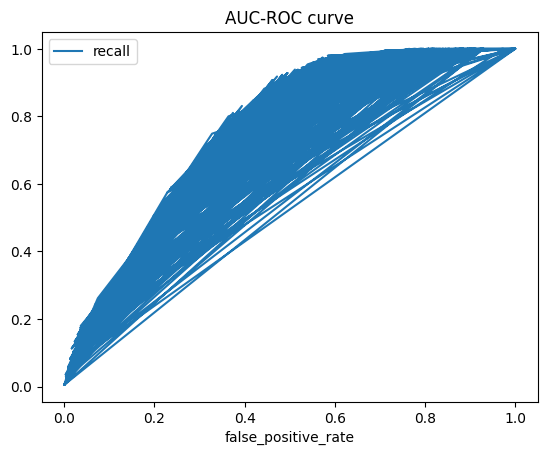

In [25]:
df_roc.plot(x="false_positive_rate", y="recall", title="AUC-ROC curve")

## Inspect global feature attributions

To provide further context to your model performance, you can use the [ML.GLOBAL_EXPLAIN](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-global-explain#get_global_feature_importance_for_each_class_of_a_boosted_tree_classifier_model) function which leverages Vertex Explainable AI as a back-end. [Vertex Explainable AI](https://cloud.google.com/vertex-ai/docs/explainable-ai) helps you understand your model's outputs for classification and regression tasks. Specifically, Vertex AI tells you how much each feature in the data contributed to your model's predicted result. You can then use this information to verify that the model is behaving as expected, identify and mitigate biases in your models, and get ideas for ways to improve your model and your training data.

In [26]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  ML.GLOBAL_EXPLAIN(MODEL bqmlga4.churn_xgb)
ORDER BY
  attribution DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,trial_id,feature,attribution
0,1,cnt_user_engagement,0.191482
1,1,user_first_engagement,0.090093
2,1,julianday,0.068122
3,1,operating_system,0.053907
4,1,cnt_post_score,0.015645
5,1,cnt_level_start_quickplay,0.014644
6,1,cnt_level_end_quickplay,0.013826
7,1,cnt_level_reset_quickplay,0.005394
8,1,language,0.005119
9,1,cnt_spend_virtual_currency,0.004703


## Generate batch predictions

You can generate batch predictions for your BQML XGBoost model using [ML.PREDICT](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-predict).

In [27]:
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  ML.PREDICT(MODEL bqmlga4.churn_xgb,
  (SELECT * FROM bqmlga4.ml_features WHERE data_split = "TEST"))

Query is running:   0%|          |

Downloading:   0%|          |

,trial_id,predicted_churned,predicted_churned_probs,user_pseudo_id,country,operating_system,language,cnt_user_engagement,cnt_level_start_quickplay,cnt_level_end_quickplay,...,cnt_ad_reward,cnt_challenge_a_friend,cnt_completed_5_levels,cnt_use_extra_steps,user_first_engagement,month,julianday,dayofweek,churned,data_split
0,1,0,"[{'label': 1, 'prob': 0.1221715435385704}, {'l...",38C93052B6B68913A433591107F8662C,United States,ANDROID,enXus,3,0,1,...,0,0,0,0,1528816138936003,6,163,3,0,TEST
1,1,0,"[{'label': 1, 'prob': 0.11438297480344772}, {'...",BE36C49B1AB3968D420923AEC4FDD7AE,Japan,ANDROID,jaXjp,6,1,1,...,0,0,0,0,1529369892467002,6,170,3,0,TEST
2,1,0,"[{'label': 1, 'prob': 0.2966190576553345}, {'l...",13E6C8A193FF140F7D4222B569DD5B50,United States,IOS,enXus,25,6,4,...,0,0,0,0,1529404147112000,6,170,3,0,TEST
3,1,0,"[{'label': 1, 'prob': 0.11686606705188751}, {'...",6CDE3BE03DAF6243A5578BCBA2D2F398,United States,IOS,enXus,2,1,0,...,0,0,0,0,1529196488711000,6,168,1,0,TEST
4,1,0,"[{'label': 1, 'prob': 0.16176098585128784}, {'...",E0937BA260FC4C21B4465D894F8BB1E6,United States,IOS,enXus,3,1,1,...,0,0,0,0,1532210222600010,7,202,7,0,TEST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,1,0,"[{'label': 1, 'prob': 0.4102441370487213}, {'l...",3D7B1658E94975AD57AAE1067AFEC49B,Canada,IOS,enXca,22,1,0,...,0,0,0,0,1530209903372017,6,179,5,1,TEST
795,1,0,"[{'label': 1, 'prob': 0.4015448987483978}, {'l...",EB98831C618794B7ED160D1EFAEC151A,United States,IOS,enXus,16,8,7,...,0,0,0,0,1536579776080003,9,253,2,1,TEST
796,1,0,"[{'label': 1, 'prob': 0.4062115550041199}, {'l...",5C2A2258C8EC6BC302BB2F231E7E5C0C,Japan,IOS,jaXgb,20,0,0,...,0,0,0,0,1536194056745016,9,249,5,1,TEST
797,1,0,"[{'label': 1, 'prob': 0.20114536583423615}, {'...",3B980CCE7EC7C895978FFEC426C8DC84,United States,ANDROID,enXus,2,0,0,...,0,0,0,0,1530458303077000,7,182,1,1,TEST


The following query returns the probability that the user will return after 24 hrs. The higher the probability and closer it is to 1, the more likely the user is predicted to churn, and the closer it is to 0, the more likely the user is predicted to return.

In [28]:
%%bigquery --project $PROJECT_ID

CREATE OR REPLACE TABLE bqmlga4.churn_predictions AS (
SELECT
  user_pseudo_id,
  churned,
  predicted_churned,
  predicted_churned_probs[OFFSET(0)].prob as probability_churned
FROM
  ML.PREDICT(MODEL bqmlga4.churn_xgb,
  (SELECT * FROM bqmlga4.ml_features))
);

Query is running:   0%|          |

""


## Export a BQML model to Vertex AI for online predictions

See the official BigQuery ML Guide: [Exporting a BigQuery ML model for online prediction](https://cloud.google.com/bigquery-ml/docs/export-model-tutorial) for additional details.

### Export BQML model to GCS

You will use the `bq extract` command in the `bq` command-line tool to export your BQML XGBoost model assets to Google Cloud Storage for persistence. See the [documentation](https://cloud.google.com/bigquery-ml/docs/exporting-models) for additional model export options.

In [29]:
BQ_MODEL = f"{BQ_DATASET}.{MODEL_NAME}"
BQ_MODEL_EXPORT_DIR = f"gs://{GCS_BUCKET}/{MODEL_NAME}"

In [30]:
!bq --location=$BQ_LOCATION extract \
--destination_format ML_XGBOOST_BOOSTER \
--model $BQ_MODEL \
$BQ_MODEL_EXPORT_DIR

Waiting on bqjob_rf344b039b198627_000001873840173b_1 ... (2s) Current status: DONE   


Navigate to [Google Cloud Storage](https://pantheon.corp.google.com/storage) in Google Cloud Console to `"gs://{GCS_BUCKET}/{MODEL_NAME}"`. Validate that you see your exported model assets in the below format:

```
|--/{GCS_BUCKET}/{MODEL_NAME}/
   |--/assets/                       # Contains preprocessing code.  
      |--0_categorical_label.txt     # Contains country vocabulary.
      |--1_categorical_label.txt     # Contains operating_system vocabulary.
      |--2_categorical_label.txt     # Contains language vocabulary.
      |--model_metadata.json         # contains model feature and label mappings.
   |--main.py                        # Can be called for local training runs.
   |--model.bst                      # XGBoost saved model format.
   |--xgboost_predictor-0.1.tar.gz   # Compress XGBoost model with prediction function. 
```

### Upload BQML model to Vertex AI from GCS

Vertex AI contains optimized pre-built training and prediction containers for popular ML frameworks such as TensorFlow, Pytorch, as well as XGBoost. You will upload your XGBoost from GCS to Vertex AI and provide the [latest pre-built Vertex XGBoost prediction container](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers) to execute your model code to generate predictions in the cells below.

In [31]:
IMAGE_URI='us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.1-4:latest'

In [33]:
model = vertexai.Model.upload(
    display_name=MODEL_NAME,
    artifact_uri=BQ_MODEL_EXPORT_DIR,
    serving_container_image_uri=IMAGE_URI,
)

Creating Model
Create Model backing LRO: projects/280186480836/locations/us-central1/models/2752836267346493440/operations/3932678008489377792
Model created. Resource name: projects/280186480836/locations/us-central1/models/2752836267346493440@1
To use this Model in another session:
model = aiplatform.Model('projects/280186480836/locations/us-central1/models/2752836267346493440@1')


### Deploy a Vertex `Endpoint` for online predictions

Before you use your model to make predictions, you need to deploy it to an `Endpoint` object. When you deploy a model to an `Endpoint`, you associate physical (machine) resources with that model to enable it to serve online predictions. Online predictions have low latency requirements; providing resources to the model in advance reduces latency. You can do this by calling the deploy function on the `Model` resource. This will do two things:

1. Create an `Endpoint` resource for deploying the `Model` resource to.
2. Deploy the `Model` resource to the `Endpoint` resource.

The `deploy()` function takes the following parameters:

* `deployed_model_display_name`: A human readable name for the deployed model.
* `traffic_split`: Percent of traffic at the endpoint that goes to this model, which is specified as a dictionary of one or more key/value pairs. If only one model, then specify as { "0": 100 }, where "0" refers to this model being uploaded and 100 means 100% of the traffic.
* `machine_type`: The type of machine to use for training.
* `accelerator_type`: The hardware accelerator type.
* `accelerator_count`: The number of accelerators to attach to a worker replica.
* `starting_replica_count`: The number of compute instances to initially provision.
* `max_replica_count`: The maximum number of compute instances to scale to. In this lab, only one instance is provisioned.
* `explanation_parameters`: Metadata to configure the Explainable AI learning method.
* `explanation_metadata`: Metadata that describes your TensorFlow model for Explainable AI such as features, input and output tensors.

Note: this can take about 3-5 minutes to provision prediction resources for your model.

In [25]:
# endpoint = model.deploy(
#     traffic_split={"0": 100},
#     machine_type="n1-standard-2",
# )

endpoint = vertexai.Endpoint('projects/280186480836/locations/us-central1/endpoints/756266087816888320')

### Query model for online predictions

XGBoost only takes numerical feature inputs. When you trained your BQML model above with CREATE MODEL statement, it automatically handled encoding of categorical features such as user `country`, `operating system`, and `language` into numeric representations. In order for our exported model to generate online predictions, you will use the categorical feature vocabulary files exported under the `assets/` folder of your model directory and the Scikit-Learn preprocessing code below to map your test instances to numeric values.

In [7]:
CATEGORICAL_FEATURES = ['country',
                        'operating_system',
                        'language']

In [4]:
!pip3 install scikit-learn --user

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.8/24.8 MB 44.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.1/38.1 MB 34.8 MB/s eta 0:00:0000:0100:01


In [3]:
from sklearn.preprocessing import OrdinalEncoder

In [4]:
def _build_cat_feature_encoders(cat_feature_list, gcs_bucket, model_name, na_value='Unknown'):
    """Build categorical feature encoders for mapping text to integers for XGBoost inference. 
    Args:
      cat_feature_list (list): List of string feature names.
      gcs_bucket (str): A string path to your Google Cloud Storage bucket.
      model_name (str): A string model directory in GCS where your BQML model was exported to.
      na_value (str): default is 'Unknown'. String value to replace any vocab NaN values prior to encoding.
    Returns:
      feature_encoders (dict): A dictionary containing OrdinalEncoder objects for integerizing 
        categorical features that has the format [feature] = feature encoder.
    """
    
    feature_encoders = {}
    
    for idx, feature in enumerate(cat_feature_list):
        feature_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        feature_vocab_file = f"gs://{gcs_bucket}/{model_name}/assets/{idx}_categorical_label.txt"
        feature_vocab_df = pd.read_csv(feature_vocab_file, delimiter = "\t", header=None).fillna(na_value)
        feature_encoder.fit(feature_vocab_df.values)
        feature_encoders[feature] = feature_encoder
    
    return feature_encoders

In [5]:
def preprocess_xgboost(instances, cat_feature_list, feature_encoders):
    """Transform instances to numerical values for inference.
    Args:
      instances (list[dict]): A list of feature dictionaries with the format feature: value. 
      cat_feature_list (list): A list of string feature names.
      feature_encoders (dict): A dictionary with the format feature: feature_encoder.
    Returns:
      transformed_instances (list[list]): A list of lists containing numerical feature values needed
        for Vertex XGBoost inference.
    """
    transformed_instances = []
    
    for instance in instances:
        for feature in cat_feature_list:
            feature_int = feature_encoders[feature].transform([[instance[feature]]]).item()
            instance[feature] = feature_int
            instance_list = list(instance.values())
        transformed_instances.append(instance_list)

    return transformed_instances

In [15]:
!pip3 install fsspec --user
!pip3 install gcsfs  --user

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 kB 3.9 MB/s eta 0:00:00a 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [16]:
# Build a dictionary of ordinal categorical feature encoders.
feature_encoders = _build_cat_feature_encoders(CATEGORICAL_FEATURES, GCS_BUCKET, MODEL_NAME)

In [17]:
%%bigquery test_df --project $PROJECT_ID 

SELECT * EXCEPT (user_pseudo_id, churned, data_split)
FROM bqmlga4.ml_features
WHERE data_split="TEST"
LIMIT 3;

Query is running:   0%|          |

Downloading:   0%|          |

In [18]:
# Convert dataframe records to feature dictionaries for preprocessing by feature name.
test_instances = test_df.astype(str).to_dict(orient='records')

In [19]:
# Apply preprocessing to transform categorical features and return numerical instances for prediction.
transformed_test_instances = preprocess_xgboost(test_instances, CATEGORICAL_FEATURES, feature_encoders)

In [26]:
# Generate predictions from model deployed to Vertex AI Endpoint.
predictions = endpoint.predict(instances=transformed_test_instances)

In [27]:
for idx, prediction in enumerate(predictions.predictions):
    # Class labels [1,0] retrieved from model_metadata.json in GCS model dir.
    # BQML binary classification default is 0.5 with above "Churn" and below "Not Churn".
    is_churned = "Churn" if prediction[0] >= 0.5 else "Not Churn"
    print(f"Prediction: Customer {idx} - {is_churned} {prediction}")
    print(test_df.iloc[idx].astype(str).to_json() + "\n")

Prediction: Customer 0 - Not Churn [0.1295643597841263, 0.8704356551170349]
{"country":"United States","operating_system":"IOS","language":"enXus","cnt_user_engagement":"3","cnt_level_start_quickplay":"1","cnt_level_end_quickplay":"1","cnt_level_complete_quickplay":"0","cnt_level_reset_quickplay":"0","cnt_post_score":"0","cnt_spend_virtual_currency":"0","cnt_ad_reward":"0","cnt_challenge_a_friend":"0","cnt_completed_5_levels":"0","cnt_use_extra_steps":"0","user_first_engagement":"1529976877237010","month":"6","julianday":"177","dayofweek":"3"}

Prediction: Customer 1 - Not Churn [0.1482318937778473, 0.8517681360244751]
{"country":"United States","operating_system":"ANDROID","language":"enXus","cnt_user_engagement":"11","cnt_level_start_quickplay":"9","cnt_level_end_quickplay":"3","cnt_level_complete_quickplay":"3","cnt_level_reset_quickplay":"4","cnt_post_score":"3","cnt_spend_virtual_currency":"0","cnt_ad_reward":"0","cnt_challenge_a_friend":"0","cnt_completed_5_levels":"0","cnt_use_e

## Next steps

Congratulations! In this lab, you trained, tuned, explained, and deployed a BigQuery ML user churn model to generate high business impact batch and online churn predictions to target customers likely to churn with interventions such as in-game rewards and reminder notifications.

In this lab, you used `user_psuedo_id` as a user identifier. As next steps, you can extend this code further by having your application return a `user_id` to Google Analytics so you can join your model's predictions with additional first-party data such as purchase history and marketing engagement data. This enables you to integrate batch predictions into Looker dashboards to help product teams prioritize user experience improvements and marketing teams create targeted user interventions such as reminder emails to improve retention. 

Through having your model in Vertex AI Prediction, you also have a scalable prediction service to call from your application to directly integrate online predictions in order to to tailor personalized user game experiences and allow for targeted habit-building notifications.

As you collect more data from your users, you may want to regularly evaluate your model on fresh data and re-train the model if you notice that the model quality is decaying. [Vertex Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/introduction) can help you to automate, monitor, and govern your ML solutions by orchestrating your BQML workflow in a serverless manner, and storing your workflow's artifacts using [Vertex ML Metadata](https://cloud.google.com/vertex-ai/docs/ml-metadata/introduction). For another alternative for continuous BQML models, checkout the blog post [Continuous model evaluation with BigQuery ML, Stored Procedures, and Cloud Scheduler](https://cloud.google.com/blog/topics/developers-practitioners/continuous-model-evaluation-bigquery-ml-stored-procedures-and-cloud-scheduler).



## License

In [ ]:
# Copyright 2021 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.